In [1]:
import os
import sys
import torch
import glob
import pandas as pd
import numpy as np
import nilearn.connectome
import matplotlib.pyplot as plt
from nilearn.input_data import NiftiLabelsMasker, NiftiMapsMasker
from csv import writer
from load_confounds import Params9

sys.path.append(os.path.join(".."))
import time_windows_dataset
import graph_construction
import gcn_model

# print("torch v{}".format(torch.__version__))
# print("nilearn v{}".format(nilearn.__version__))
# print("simexp_gcn v{}".format(simexp_gcn.__version__))

/home/SRastegarnia/.virtualenvs/hcptrtr_gcn_env/lib/python3.6/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.6 support is deprecated and will be removed in release 0.10 of Nilearn. Consider switching to Python 3.8 or 3.9.
  _python_deprecation_warnings()
/home/SRastegarnia/.virtualenvs/hcptrtr_gcn_env/lib/python3.6/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
# clf = RidgeCV(alphas=[100, 200, 300, 400, 600,  800, 900, 1000, 1200]) 

# Initial parameters

In [3]:
TR = 1.49
random_seed = 0

subject = 'sub-01'
region_approach = 'MIST'
resolution = 444
window_length = 1
modality = 'all_mod' #'motor'
HRFlag_processes = '3volumes'

# Fetch data

In [4]:
# paths
data_dir = os.path.join('..', '..', '..', 'data')

concat_data_dir = os.path.join(data_dir, 'concat_data', region_approach, str(resolution), subject)
processed_bold_files = sorted(glob.glob(concat_data_dir + '/*.npy'))

conn_dir = os.path.join(data_dir, 'connectomes')
conn_files = sorted(glob.glob(conn_dir + '/conn_wavg_2runs_hcptrt_{}_{}{}.npy'.format(subject,
                                                                                region_approach,
                                                                                resolution)))#/conn_30mins_friends_
split_dir = os.path.join(data_dir, 'split_win_data')
out_csv = os.path.join(split_dir, 'labels.csv')
out_file = os.path.join(split_dir, '{}_{:04d}.npy')

result_dir = os.path.join('../results')
result_csv = os.path.join(result_dir, 'result_df.csv')
model_path = os.path.join('../models', 'gcn_test.pt')

In [5]:
if not os.path.exists(split_dir):
    os.makedirs(split_dir)
if not os.path.exists(conn_dir):
    os.makedirs(conn_dir)    
if not os.path.exists(result_dir):
    os.makedirs(result_dir)
if not os.path.exists(result_csv):
    result_df = pd.DataFrame(columns=['subject','modality','window_length','region_approach',
                                      'average_loss','average_accuracy', 'time_window'])
    result_df.to_csv(result_csv, index=False)
    
# remove previous content
if os.path.exists(split_dir):
    files = glob.glob(os.path.join(split_dir, "*"))
    for f in files:
        os.remove(f)

In [6]:
path = '/home/SRastegarnia/hcptrt_decoding_Shima/data/concat_data/'\
       '{}/{}/{}'.format(region_approach, resolution, subject)

test_path_body0b = os.path.join(path, '{}_body0b_3volumes_concat_fMRI.npy'.format(subject))
test_path_body2b = os.path.join(path, '{}_body2b_3volumes_concat_fMRI.npy'.format(subject))
test_path_face0b = os.path.join(path, '{}_face0b_3volumes_concat_fMRI.npy'.format(subject))
test_path_face2b = os.path.join(path, '{}_face2b_3volumes_concat_fMRI.npy'.format(subject))
test_path_fear = os.path.join(path, '{}_fear_3volumes_concat_fMRI.npy'.format(subject))
test_path_footL = os.path.join(path, '{}_footL_3volumes_concat_fMRI.npy'.format(subject))
test_path_footR = os.path.join(path, '{}_footR_3volumes_concat_fMRI.npy'.format(subject))
test_path_handL = os.path.join(path, '{}_handL_3volumes_concat_fMRI.npy'.format(subject))
test_path_handR = os.path.join(path, '{}_handR_3volumes_concat_fMRI.npy'.format(subject))
test_path_match = os.path.join(path, '{}_match_3volumes_concat_fMRI.npy'.format(subject))
test_path_math = os.path.join(path, '{}_math_3volumes_concat_fMRI.npy'.format(subject))
test_path_mental = os.path.join(path, '{}_mental_3volumes_concat_fMRI.npy'.format(subject))
test_path_place0b = os.path.join(path, '{}_place0b_3volumes_concat_fMRI.npy'.format(subject))
test_path_place2b = os.path.join(path, '{}_place2b_3volumes_concat_fMRI.npy'.format(subject))
test_path_random = os.path.join(path, '{}_random_3volumes_concat_fMRI.npy'.format(subject))
test_path_relational = os.path.join(path, '{}_relational_3volumes_concat_fMRI.npy'.format(subject))
test_path_shape = os.path.join(path, '{}_shape_3volumes_concat_fMRI.npy'.format(subject))
test_path_story = os.path.join(path, '{}_story_3volumes_concat_fMRI.npy'.format(subject))
test_path_tongue = os.path.join(path, '{}_tongue_3volumes_concat_fMRI.npy'.format(subject))
test_path_tool0b = os.path.join(path, '{}_tool0b_3volumes_concat_fMRI.npy'.format(subject))
test_path_tool0b = os.path.join(path, '{}_tool0b_3volumes_concat_fMRI.npy'.format(subject))

a = np.load(test_path_body0b)
b = np.load(test_path_body2b)
c = np.load(test_path_face0b)
d = np.load(test_path_face2b)
e = np.load(test_path_fear)

print('body0b', len(a))
print('body2b', len(b))
print('face0b', len(c))
print('face2b', len(d))
print('fear', len(e))

body0b 306
body2b 248
face0b 304
face2b 296
fear 293


# Generating connectomes

In [7]:
# # دیگه استفاده نمیشه. برای یک اپیزود فرندز بود
# # Generates connectome from friends for GCN

# bold_suffix = '_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
# path_cneuromod = '/data/neuromod/projects/ml_models_tutorial/data/friends/raw_data'
# file_epi = os.path.join(path_cneuromod, 
#                         'sub-01_ses-003_task-s01e05a_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')

# conf = Params9()
# masker = NiftiLabelsMasker(labels_img = '../MIST_444.nii.gz', standardize=True, 
#                            smoothing_fwhm = 5, verbose=5)
# sample_ts = masker.fit_transform(file_epi, confounds=conf.load(file_epi)) 
# print(sample_ts.shape)

# # Estimating connectomes
# corr_measure = nilearn.connectome.ConnectivityMeasure(kind="correlation")
# conn = corr_measure.fit_transform([sample_ts])[0]
# np.save(os.path.join(conn_dir, 'conn_friends_{}_{}{}.npy'.format(subject, region_approach, 
#                                                                         resolution)), conn)

In [8]:
# # فقط یک بار نیاز است که اجرا شود و فایل ذخیره شده
# # Generates connectome from 30 mins of friens for GCN

# bold_suffix = '_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
# # path_cneuromod = '/data/neuromod/projects/ml_models_tutorial/data/friends/raw_data/' #friends
# path_cneuromod = '/data/neuromod/projects/ml_models_tutorial/data/hcptrt/temp/sub-01/ses-003/'
# files_epi = sorted(glob.glob(path_cneuromod + '{}_*_space-MNI152NLin2009cAsym'\
#                              '_desc-preproc_bold.nii.gz'.format(subject)))
# print(files_epi)
# conf = Params9()
# masker = NiftiLabelsMasker(labels_img = '../MIST_444.nii.gz', standardize=True, 
#                            smoothing_fwhm = 5, verbose=5)

# connectom_idx = []
# for file_epi in files_epi:
#     print(file_epi)
#     sample_ts = masker.fit_transform(file_epi, confounds=conf.load(file_epi)) 
#     corr_measure = nilearn.connectome.ConnectivityMeasure(kind="correlation")
#     conn = corr_measure.fit_transform([sample_ts])[0]
#     connectom_idx.append(conn)
    
# wts = np.array([.5,1.5,.5,.5,1,2])
# np.save(os.path.join(conn_dir, 'conn_wavg_2runs_hcptrt_{}_{}{}.npy'.format(subject, region_approach, 
#                                                                             resolution)), 
#         np.average(connectom_idx, axis=0, weights = wts)) # conn_30mins_friends_

# # conn_file = os.path.join(conn_dir, 'conn_friends_{}_{}{}.npy'.format(subject, region_approach, resolution))
# # print(conn_file)
# # a = np.load(conn_file)
# # print(np.shape(a))

In [9]:
conn_file = os.path.join(conn_dir, 'conn_wavg_2runs_hcptrt_{}_{}{}.npy'.format(subject, region_approach, resolution))
print(conn_file)
a = np.load(conn_file)
print(np.shape(a))

../../../data/connectomes/conn_wavg_2runs_hcptrt_sub-01_MIST444.npy
(444, 444)


# Split timeseries & generate label file

In [10]:
dic_labels = {'body0b':0,'body2b':1,'face0b':2,'face2b':3,'fear':4,'footL':5,'footR':6,
              'handL':7,'handR':8,'match':9,'math':10,'mental':11,'place0b':12,'place2b':13, 
              'random':14,'relational':15,'shape':16,'story':17,'tongue':18,'tool0b':19,'tool2b':20}


label_df = pd.DataFrame(columns=['label', 'filename'])
# print(len(processed_bold_files))

for proc_bold in processed_bold_files:
    
    ts_data = np.load(proc_bold)
#     print(ts_data)

    ts_duration = len(ts_data)
#     print(ts_duration)

    ts_filename = os.path.basename(proc_bold)
    ts_filename = "".join(ts_filename.split(".")[:-1])
    print(ts_filename)
    
    ts_label = ts_filename.split(subject+'_', 1)[1].split('_'+HRFlag_processes, 1)[0]
    print('ts_label:', ts_label)
    
    valid_label = dic_labels[ts_label]
    
    # Split the timeseries
    rem = ts_duration % window_length
    n_splits = int(np.floor(ts_duration / window_length))
    print('n_splits:', n_splits)
    ts_data = ts_data[:(ts_duration-rem), :]
    print('ts_data shape after removing rem:', np.shape(ts_data), '\n')    
    
    for j, split_ts in enumerate(np.split(ts_data, n_splits)):
        ts_output_file_name = out_file.format(ts_filename, j)
        print('ts_output_file_name:', ts_output_file_name)        
#         print('shape split_ts:', np.shape(split_ts))
#         print('split_ts:', split_ts)

        split_ts = np.swapaxes(split_ts, 0, 1)
        np.save(ts_output_file_name, split_ts)
        curr_label = {'label': valid_label, 'filename': os.path.basename(ts_output_file_name)}
        label_df = label_df.append(curr_label, ignore_index=True)
    print('------------------------------------------------------------------------------------------------')
    
label_df.to_csv(out_csv, index=False)        

sub-01_body0b_3volumes_concat_fMRI
ts_label: body0b
n_splits: 306
ts_data shape after removing rem: (306, 444) 

ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0000.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0001.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0002.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0003.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0004.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0005.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0006.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0007.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0008.npy
ts_output_file_name: ../../../data/split_

ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0089.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0090.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0091.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0092.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0093.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0094.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0095.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0096.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0097.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0098.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_bod

ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0178.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0179.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0180.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0181.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0182.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0183.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0184.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0185.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0186.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0187.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_bod

ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0267.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0268.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0269.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0270.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0271.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0272.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0273.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0274.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0275.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body0b_3volumes_concat_fMRI_0276.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_bod

ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0050.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0051.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0052.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0053.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0054.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0055.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0056.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0057.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0058.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0059.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_bod

ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0142.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0143.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0144.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0145.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0146.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0147.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0148.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0149.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0150.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0151.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_bod

ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0235.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0236.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0237.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0238.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0239.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0240.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0241.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0242.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0243.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_body2b_3volumes_concat_fMRI_0244.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_bod

ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0072.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0073.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0074.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0075.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0076.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0077.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0078.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0079.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0080.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0081.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fac

ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0169.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0170.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0171.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0172.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0173.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0174.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0175.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0176.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0177.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0178.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fac

ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0264.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0265.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0266.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0267.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0268.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0269.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0270.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0271.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0272.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face0b_3volumes_concat_fMRI_0273.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fac

ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0045.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0046.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0047.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0048.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0049.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0050.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0051.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0052.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0053.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0054.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fac

ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0133.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0134.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0135.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0136.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0137.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0138.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0139.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0140.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0141.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0142.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fac

ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0225.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0226.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0227.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0228.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0229.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0230.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0231.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0232.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0233.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_face2b_3volumes_concat_fMRI_0234.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fac

ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0017.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0018.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0019.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0020.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0021.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0022.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0023.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0024.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0025.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0026.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fM

ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0116.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0117.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0118.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0119.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0120.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0121.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0122.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0123.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0124.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0125.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fM

ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0214.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0215.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0216.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0217.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0218.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0219.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0220.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0221.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0222.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fMRI_0223.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_fear_3volumes_concat_fM

ts_output_file_name: ../../../data/split_win_data/sub-01_footL_3volumes_concat_fMRI_0008.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footL_3volumes_concat_fMRI_0009.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footL_3volumes_concat_fMRI_0010.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footL_3volumes_concat_fMRI_0011.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footL_3volumes_concat_fMRI_0012.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footL_3volumes_concat_fMRI_0013.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footL_3volumes_concat_fMRI_0014.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footL_3volumes_concat_fMRI_0015.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footL_3volumes_concat_fMRI_0016.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footL_3volumes_concat_fMRI_0017.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footL_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_footL_3volumes_concat_fMRI_0097.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footL_3volumes_concat_fMRI_0098.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footL_3volumes_concat_fMRI_0099.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footL_3volumes_concat_fMRI_0100.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footL_3volumes_concat_fMRI_0101.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footL_3volumes_concat_fMRI_0102.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footL_3volumes_concat_fMRI_0103.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footL_3volumes_concat_fMRI_0104.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footL_3volumes_concat_fMRI_0105.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footL_3volumes_concat_fMRI_0106.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footL_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_footR_3volumes_concat_fMRI_0038.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footR_3volumes_concat_fMRI_0039.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footR_3volumes_concat_fMRI_0040.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footR_3volumes_concat_fMRI_0041.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footR_3volumes_concat_fMRI_0042.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footR_3volumes_concat_fMRI_0043.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footR_3volumes_concat_fMRI_0044.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footR_3volumes_concat_fMRI_0045.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footR_3volumes_concat_fMRI_0046.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footR_3volumes_concat_fMRI_0047.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footR_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_footR_3volumes_concat_fMRI_0133.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footR_3volumes_concat_fMRI_0134.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footR_3volumes_concat_fMRI_0135.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footR_3volumes_concat_fMRI_0136.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footR_3volumes_concat_fMRI_0137.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footR_3volumes_concat_fMRI_0138.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footR_3volumes_concat_fMRI_0139.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footR_3volumes_concat_fMRI_0140.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footR_3volumes_concat_fMRI_0141.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footR_3volumes_concat_fMRI_0142.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_footR_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_handL_3volumes_concat_fMRI_0079.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handL_3volumes_concat_fMRI_0080.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handL_3volumes_concat_fMRI_0081.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handL_3volumes_concat_fMRI_0082.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handL_3volumes_concat_fMRI_0083.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handL_3volumes_concat_fMRI_0084.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handL_3volumes_concat_fMRI_0085.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handL_3volumes_concat_fMRI_0086.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handL_3volumes_concat_fMRI_0087.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handL_3volumes_concat_fMRI_0088.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handL_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_handR_3volumes_concat_fMRI_0023.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handR_3volumes_concat_fMRI_0024.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handR_3volumes_concat_fMRI_0025.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handR_3volumes_concat_fMRI_0026.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handR_3volumes_concat_fMRI_0027.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handR_3volumes_concat_fMRI_0028.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handR_3volumes_concat_fMRI_0029.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handR_3volumes_concat_fMRI_0030.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handR_3volumes_concat_fMRI_0031.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handR_3volumes_concat_fMRI_0032.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handR_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_handR_3volumes_concat_fMRI_0113.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handR_3volumes_concat_fMRI_0114.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handR_3volumes_concat_fMRI_0115.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handR_3volumes_concat_fMRI_0116.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handR_3volumes_concat_fMRI_0117.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handR_3volumes_concat_fMRI_0118.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handR_3volumes_concat_fMRI_0119.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handR_3volumes_concat_fMRI_0120.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handR_3volumes_concat_fMRI_0121.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handR_3volumes_concat_fMRI_0122.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_handR_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0057.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0058.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0059.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0060.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0061.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0062.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0063.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0064.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0065.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0066.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0147.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0148.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0149.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0150.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0151.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0152.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0153.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0154.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0155.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0156.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0243.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0244.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0245.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0246.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0247.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0248.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0249.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0250.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0251.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0252.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0332.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0333.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0334.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0335.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0336.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0337.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0338.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0339.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0340.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0341.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0428.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0429.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0430.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0431.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0432.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0433.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0434.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0435.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0436.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volumes_concat_fMRI_0437.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_match_3volume

------------------------------------------------------------------------------------------------
sub-01_math_3volumes_concat_fMRI
ts_label: math
n_splits: 1028
ts_data shape after removing rem: (1028, 444) 

ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0000.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0001.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0002.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0003.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0004.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0005.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0006.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0007.npy
ts_output_file_name: ../../../data/split_win_data/sub-01

ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0087.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0088.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0089.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0090.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0091.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0092.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0093.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0094.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0095.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0096.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fM

ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0177.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0178.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0179.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0180.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0181.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0182.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0183.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0184.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0185.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0186.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fM

ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0269.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0270.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0271.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0272.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0273.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0274.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0275.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0276.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0277.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0278.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fM

ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0361.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0362.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0363.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0364.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0365.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0366.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0367.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0368.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0369.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0370.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fM

ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0452.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0453.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0454.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0455.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0456.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0457.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0458.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0459.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0460.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0461.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fM

ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0553.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0554.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0555.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0556.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0557.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0558.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0559.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0560.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0561.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0562.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fM

ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0645.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0646.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0647.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0648.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0649.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0650.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0651.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0652.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0653.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0654.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fM

ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0741.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0742.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0743.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0744.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0745.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0746.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0747.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0748.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0749.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0750.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fM

ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0831.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0832.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0833.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0834.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0835.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0836.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0837.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0838.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0839.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0840.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fM

ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0928.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0929.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0930.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0931.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0932.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0933.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0934.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0935.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0936.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_0937.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fM

ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_1026.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_math_3volumes_concat_fMRI_1027.npy
------------------------------------------------------------------------------------------------
sub-01_mental_3volumes_concat_fMRI
ts_label: mental
n_splits: 809
ts_data shape after removing rem: (809, 444) 

ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0000.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0001.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0002.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0003.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0004.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0005.npy
ts_output_file_name: ../../../data/split_w

ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0084.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0085.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0086.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0087.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0088.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0089.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0090.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0091.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0092.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0093.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_men

ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0172.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0173.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0174.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0175.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0176.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0177.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0178.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0179.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0180.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0181.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_men

ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0265.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0266.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0267.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0268.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0269.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0270.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0271.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0272.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0273.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0274.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_men

ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0354.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0355.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0356.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0357.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0358.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0359.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0360.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0361.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0362.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0363.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_men

ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0449.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0450.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0451.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0452.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0453.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0454.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0455.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0456.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0457.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0458.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_men

ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0539.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0540.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0541.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0542.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0543.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0544.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0545.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0546.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0547.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0548.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_men

ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0642.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0643.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0644.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0645.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0646.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0647.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0648.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0649.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0650.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0651.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_men

ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0737.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0738.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0739.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0740.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0741.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0742.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0743.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0744.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0745.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_mental_3volumes_concat_fMRI_0746.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_men

ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0020.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0021.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0022.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0023.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0024.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0025.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0026.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0027.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0028.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0029.npy
ts_output_file_name: ../../../data/split_win_data/

ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0112.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0113.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0114.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0115.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0116.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0117.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0118.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0119.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0120.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0121.npy
ts_output_file_name: ../../../data/split_win_data/

ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0204.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0205.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0206.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0207.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0208.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0209.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0210.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0211.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0212.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place0b_3volumes_concat_fMRI_0213.npy
ts_output_file_name: ../../../data/split_win_data/

ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0035.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0036.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0037.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0038.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0039.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0040.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0041.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0042.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0043.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0044.npy
ts_output_file_name: ../../../data/split_win_data/

ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0126.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0127.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0128.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0129.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0130.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0131.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0132.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0133.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0134.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0135.npy
ts_output_file_name: ../../../data/split_win_data/

ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0220.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0221.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0222.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0223.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0224.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0225.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0226.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0227.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0228.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_place2b_3volumes_concat_fMRI_0229.npy
ts_output_file_name: ../../../data/split_win_data/

ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0032.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0033.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0034.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0035.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0036.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0037.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0038.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0039.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0040.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0041.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_ran

ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0128.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0129.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0130.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0131.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0132.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0133.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0134.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0135.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0136.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0137.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_ran

ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0216.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0217.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0218.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0219.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0220.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0221.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0222.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0223.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0224.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0225.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_ran

ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0312.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0313.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0314.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0315.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0316.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0317.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0318.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0319.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0320.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0321.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_ran

ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0406.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0407.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0408.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0409.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0410.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0411.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0412.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0413.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0414.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0415.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_ran

ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0499.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0500.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0501.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0502.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0503.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0504.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0505.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0506.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0507.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0508.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_ran

ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0597.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0598.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0599.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0600.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0601.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0602.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0603.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0604.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0605.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0606.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_ran

ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0691.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0692.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0693.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0694.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0695.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0696.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0697.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0698.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0699.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_random_3volumes_concat_fMRI_0700.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_ran

ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0037.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0038.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0039.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0040.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0041.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0042.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0043.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0044.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0045.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0046.npy
ts_output_file_name:

ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0130.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0131.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0132.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0133.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0134.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0135.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0136.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0137.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0138.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0139.npy
ts_output_file_name:

ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0224.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0225.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0226.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0227.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0228.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0229.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0230.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0231.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0232.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0233.npy
ts_output_file_name:

ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0318.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0319.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0320.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0321.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0322.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0323.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0324.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0325.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0326.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0327.npy
ts_output_file_name:

ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0410.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0411.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0412.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0413.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0414.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0415.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0416.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0417.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0418.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_relational_3volumes_concat_fMRI_0419.npy
ts_output_file_name:

ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0047.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0048.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0049.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0050.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0051.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0052.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0053.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0054.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0055.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0056.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0138.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0139.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0140.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0141.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0142.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0143.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0144.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0145.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0146.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0147.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0238.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0239.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0240.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0241.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0242.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0243.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0244.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0245.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0246.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0247.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0338.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0339.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0340.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0341.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0342.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0343.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0344.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0345.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0346.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volumes_concat_fMRI_0347.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_shape_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0049.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0050.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0051.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0052.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0053.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0054.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0055.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0056.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0057.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0058.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0144.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0145.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0146.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0147.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0148.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0149.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0150.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0151.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0152.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0153.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0233.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0234.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0235.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0236.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0237.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0238.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0239.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0240.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0241.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0242.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0324.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0325.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0326.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0327.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0328.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0329.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0330.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0331.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0332.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0333.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0416.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0417.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0418.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0419.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0420.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0421.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0422.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0423.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0424.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0425.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0505.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0506.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0507.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0508.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0509.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0510.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0511.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0512.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0513.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0514.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0600.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0601.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0602.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0603.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0604.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0605.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0606.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0607.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0608.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0609.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0689.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0690.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0691.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0692.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0693.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0694.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0695.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0696.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0697.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0698.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0786.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0787.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0788.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0789.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0790.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0791.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0792.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0793.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0794.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0795.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0885.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0886.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0887.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0888.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0889.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0890.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0891.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0892.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0893.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volumes_concat_fMRI_0894.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_story_3volume

ts_output_file_name: ../../../data/split_win_data/sub-01_tongue_3volumes_concat_fMRI_0074.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tongue_3volumes_concat_fMRI_0075.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tongue_3volumes_concat_fMRI_0076.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tongue_3volumes_concat_fMRI_0077.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tongue_3volumes_concat_fMRI_0078.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tongue_3volumes_concat_fMRI_0079.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tongue_3volumes_concat_fMRI_0080.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tongue_3volumes_concat_fMRI_0081.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tongue_3volumes_concat_fMRI_0082.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tongue_3volumes_concat_fMRI_0083.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_ton

ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0019.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0020.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0021.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0022.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0023.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0024.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0025.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0026.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0027.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0028.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_too

ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0107.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0108.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0109.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0110.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0111.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0112.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0113.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0114.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0115.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0116.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_too

ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0204.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0205.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0206.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0207.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0208.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0209.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0210.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0211.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0212.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool0b_3volumes_concat_fMRI_0213.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_too

ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0012.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0013.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0014.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0015.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0016.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0017.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0018.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0019.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0020.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0021.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_too

ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0100.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0101.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0102.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0103.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0104.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0105.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0106.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0107.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0108.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0109.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_too

ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0196.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0197.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0198.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0199.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0200.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0201.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0202.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0203.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0204.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_tool2b_3volumes_concat_fMRI_0205.npy
ts_output_file_name: ../../../data/split_win_data/sub-01_too

In [11]:
# Pytorch dataset: generates items from the current data directory
train_dataset = time_windows_dataset.TimeWindowsDataset(
    data_dir=split_dir
    , partition="train"
    , random_seed=random_seed
    , pin_memory=True
    , normalize=True,shuffle = True)
valid_dataset = time_windows_dataset.TimeWindowsDataset(
    data_dir=split_dir
    , partition="valid"
    , random_seed=random_seed
    , pin_memory=True
    , normalize=True, shuffle = True)
test_dataset = time_windows_dataset.TimeWindowsDataset(
    data_dir=split_dir
    , partition="test"
    , random_seed=random_seed
    , pin_memory=True
    , normalize=True, shuffle = True)
print("train dataset: {}".format(train_dataset))
print("valid dataset: {}".format(valid_dataset))
print("test dataset: {}".format(test_dataset))

train dataset: 5670*(torch.Size([444, 1]), ())
valid dataset: 1620*(torch.Size([444, 1]), ())
test dataset: 811*(torch.Size([444, 1]), ())


In [12]:
# Pytorch dataloader: wraps an iterable around pytorch dataset to shuffle & generate (in parrallel) minibatches
#setting pytoch seed for reproducible torch.utils.data.DataLoader
torch.manual_seed(random_seed)
train_generator = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True)
valid_generator = torch.utils.data.DataLoader(valid_dataset, batch_size=10, shuffle=True)
test_generator = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=True)
train_features, train_labels = next(iter(train_generator))
print(f"Feature batch shape: {train_features.size()}; mean {torch.mean(train_features)}")
print(f"Labels batch shape: {train_labels.size()}; mean {torch.mean(torch.Tensor.float(train_labels))}")

Feature batch shape: torch.Size([10, 444, 1]); mean 0.0
Labels batch shape: torch.Size([10]); mean 11.0


# Model definition

In [13]:
## model definition
## get average connectome with its k-nearest neighbors

connectomes = []
for conn_file in conn_files:
    print(conn_file)
    connectomes += [np.load(conn_file)]

    
# conn_file = os.path.join(conn_dir, 'conn_{}_{}.npy'.format(subject, region_approach))
# connectomes = np.load(conn_file)
    
# connectomes = np.load('../../data/connectomes/conn_30mins_sub-01_MIST_444.npy')   
    
# connectomes = RawDataLoad.get_valid_connectomes()
graph = graph_construction.make_group_graph(connectomes, k=8, self_loops=False, symmetric=True)

## Create model
gcn = gcn_model.GCN(graph.edge_index, graph.edge_attr, 
                    n_timepoints=window_length, resolution=resolution)
gcn

../../../data/connectomes/conn_wavg_2runs_hcptrt_sub-01_MIST444.npy


GCN(
  (conv1): ChebConv(1, 32, K=2, normalization=sym)
  (conv2): ChebConv(32, 32, K=2, normalization=sym)
  (conv3): ChebConv(32, 32, K=2, normalization=sym)
  (conv4): ChebConv(32, 32, K=2, normalization=sym)
  (conv5): ChebConv(32, 32, K=2, normalization=sym)
  (conv6): ChebConv(32, 32, K=2, normalization=sym)
  (fc1): Linear(in_features=14208, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=21, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

# Training

In [14]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)    
    model = model.double() #shima    
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X.double())# shima
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss, current = loss.item(), batch * dataloader.batch_size #Loic

        correct = (pred.argmax(1) == y).type(torch.float).sum().item()
        correct /= X.shape[0]
        print(f"#{batch:>5};\ttrain_loss: {loss:>0.3f};\ttrain_accuracy:{(100*correct):>5.1f}%\t\t[{current:>5d}/{size:>5d}]")

def valid_test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model.forward(X)
            loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= size
    correct /= size

    return loss, correct

In [15]:
# Train and evaluate the model
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gcn.parameters(), lr=1e-4, weight_decay=5e-4)

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}/{epochs}\n-------------------------------")
    train_loop(train_generator, gcn, loss_fn, optimizer)
    loss, correct = valid_test_loop(valid_generator, gcn, loss_fn)
    print(f"Valid metrics:\n\t avg_loss: {loss:>8f};\t avg_accuracy: {(100*correct):>0.1f}%")
print("Done!")

Epoch 1/5
-------------------------------
#    0;	train_loss: 3.040;	train_accuracy: 10.0%		[    0/ 5670]
#    1;	train_loss: 2.981;	train_accuracy: 20.0%		[   10/ 5670]
#    2;	train_loss: 2.916;	train_accuracy: 20.0%		[   20/ 5670]
#    3;	train_loss: 3.088;	train_accuracy: 10.0%		[   30/ 5670]
#    4;	train_loss: 2.986;	train_accuracy: 20.0%		[   40/ 5670]
#    5;	train_loss: 2.914;	train_accuracy: 20.0%		[   50/ 5670]
#    6;	train_loss: 3.210;	train_accuracy:  0.0%		[   60/ 5670]
#    7;	train_loss: 3.022;	train_accuracy: 10.0%		[   70/ 5670]
#    8;	train_loss: 3.024;	train_accuracy: 10.0%		[   80/ 5670]
#    9;	train_loss: 2.963;	train_accuracy: 10.0%		[   90/ 5670]
#   10;	train_loss: 3.156;	train_accuracy:  0.0%		[  100/ 5670]
#   11;	train_loss: 2.809;	train_accuracy: 20.0%		[  110/ 5670]
#   12;	train_loss: 2.868;	train_accuracy: 10.0%		[  120/ 5670]
#   13;	train_loss: 2.921;	train_accuracy: 20.0%		[  130/ 5670]
#   14;	train_loss: 2.795;	train_accuracy: 20.0%		[  140/ 5670

#  128;	train_loss: 2.946;	train_accuracy: 20.0%		[ 1280/ 5670]
#  129;	train_loss: 2.895;	train_accuracy: 20.0%		[ 1290/ 5670]
#  130;	train_loss: 2.507;	train_accuracy: 30.0%		[ 1300/ 5670]
#  131;	train_loss: 2.486;	train_accuracy: 30.0%		[ 1310/ 5670]
#  132;	train_loss: 2.924;	train_accuracy: 20.0%		[ 1320/ 5670]
#  133;	train_loss: 2.539;	train_accuracy: 40.0%		[ 1330/ 5670]
#  134;	train_loss: 2.730;	train_accuracy: 30.0%		[ 1340/ 5670]
#  135;	train_loss: 2.533;	train_accuracy: 30.0%		[ 1350/ 5670]
#  136;	train_loss: 2.496;	train_accuracy: 10.0%		[ 1360/ 5670]
#  137;	train_loss: 2.401;	train_accuracy: 30.0%		[ 1370/ 5670]
#  138;	train_loss: 2.373;	train_accuracy: 30.0%		[ 1380/ 5670]
#  139;	train_loss: 3.319;	train_accuracy: 20.0%		[ 1390/ 5670]
#  140;	train_loss: 1.783;	train_accuracy: 60.0%		[ 1400/ 5670]
#  141;	train_loss: 2.576;	train_accuracy: 40.0%		[ 1410/ 5670]
#  142;	train_loss: 2.938;	train_accuracy: 20.0%		[ 1420/ 5670]
#  143;	train_loss: 2.439;	train_accurac

#  257;	train_loss: 2.740;	train_accuracy: 20.0%		[ 2570/ 5670]
#  258;	train_loss: 2.427;	train_accuracy: 20.0%		[ 2580/ 5670]
#  259;	train_loss: 1.993;	train_accuracy: 40.0%		[ 2590/ 5670]
#  260;	train_loss: 2.074;	train_accuracy: 30.0%		[ 2600/ 5670]
#  261;	train_loss: 3.155;	train_accuracy: 10.0%		[ 2610/ 5670]
#  262;	train_loss: 2.796;	train_accuracy: 20.0%		[ 2620/ 5670]
#  263;	train_loss: 2.313;	train_accuracy: 30.0%		[ 2630/ 5670]
#  264;	train_loss: 1.902;	train_accuracy: 50.0%		[ 2640/ 5670]
#  265;	train_loss: 2.491;	train_accuracy: 20.0%		[ 2650/ 5670]
#  266;	train_loss: 2.708;	train_accuracy: 20.0%		[ 2660/ 5670]
#  267;	train_loss: 3.003;	train_accuracy: 10.0%		[ 2670/ 5670]
#  268;	train_loss: 2.824;	train_accuracy: 20.0%		[ 2680/ 5670]
#  269;	train_loss: 2.951;	train_accuracy: 10.0%		[ 2690/ 5670]
#  270;	train_loss: 2.156;	train_accuracy: 30.0%		[ 2700/ 5670]
#  271;	train_loss: 2.263;	train_accuracy: 30.0%		[ 2710/ 5670]
#  272;	train_loss: 2.479;	train_accurac

#  386;	train_loss: 2.383;	train_accuracy: 30.0%		[ 3860/ 5670]
#  387;	train_loss: 2.315;	train_accuracy: 50.0%		[ 3870/ 5670]
#  388;	train_loss: 2.424;	train_accuracy: 30.0%		[ 3880/ 5670]
#  389;	train_loss: 2.308;	train_accuracy: 20.0%		[ 3890/ 5670]
#  390;	train_loss: 2.990;	train_accuracy: 10.0%		[ 3900/ 5670]
#  391;	train_loss: 2.443;	train_accuracy: 30.0%		[ 3910/ 5670]
#  392;	train_loss: 1.861;	train_accuracy: 50.0%		[ 3920/ 5670]
#  393;	train_loss: 2.561;	train_accuracy: 30.0%		[ 3930/ 5670]
#  394;	train_loss: 1.738;	train_accuracy: 50.0%		[ 3940/ 5670]
#  395;	train_loss: 2.831;	train_accuracy: 20.0%		[ 3950/ 5670]
#  396;	train_loss: 2.261;	train_accuracy: 40.0%		[ 3960/ 5670]
#  397;	train_loss: 2.396;	train_accuracy: 30.0%		[ 3970/ 5670]
#  398;	train_loss: 2.044;	train_accuracy: 20.0%		[ 3980/ 5670]
#  399;	train_loss: 2.494;	train_accuracy: 20.0%		[ 3990/ 5670]
#  400;	train_loss: 2.055;	train_accuracy: 30.0%		[ 4000/ 5670]
#  401;	train_loss: 2.076;	train_accurac

#  515;	train_loss: 2.327;	train_accuracy: 20.0%		[ 5150/ 5670]
#  516;	train_loss: 2.922;	train_accuracy: 10.0%		[ 5160/ 5670]
#  517;	train_loss: 1.913;	train_accuracy: 50.0%		[ 5170/ 5670]
#  518;	train_loss: 2.193;	train_accuracy: 20.0%		[ 5180/ 5670]
#  519;	train_loss: 1.600;	train_accuracy: 50.0%		[ 5190/ 5670]
#  520;	train_loss: 2.249;	train_accuracy: 30.0%		[ 5200/ 5670]
#  521;	train_loss: 2.350;	train_accuracy: 30.0%		[ 5210/ 5670]
#  522;	train_loss: 2.136;	train_accuracy: 40.0%		[ 5220/ 5670]
#  523;	train_loss: 2.073;	train_accuracy: 40.0%		[ 5230/ 5670]
#  524;	train_loss: 1.868;	train_accuracy: 40.0%		[ 5240/ 5670]
#  525;	train_loss: 1.273;	train_accuracy: 60.0%		[ 5250/ 5670]
#  526;	train_loss: 2.276;	train_accuracy: 40.0%		[ 5260/ 5670]
#  527;	train_loss: 2.686;	train_accuracy: 20.0%		[ 5270/ 5670]
#  528;	train_loss: 2.070;	train_accuracy: 50.0%		[ 5280/ 5670]
#  529;	train_loss: 2.114;	train_accuracy: 50.0%		[ 5290/ 5670]
#  530;	train_loss: 2.302;	train_accurac

#   75;	train_loss: 1.940;	train_accuracy: 50.0%		[  750/ 5670]
#   76;	train_loss: 1.839;	train_accuracy: 50.0%		[  760/ 5670]
#   77;	train_loss: 1.167;	train_accuracy: 70.0%		[  770/ 5670]
#   78;	train_loss: 2.638;	train_accuracy: 30.0%		[  780/ 5670]
#   79;	train_loss: 2.127;	train_accuracy: 40.0%		[  790/ 5670]
#   80;	train_loss: 1.614;	train_accuracy: 60.0%		[  800/ 5670]
#   81;	train_loss: 1.448;	train_accuracy: 60.0%		[  810/ 5670]
#   82;	train_loss: 2.500;	train_accuracy: 40.0%		[  820/ 5670]
#   83;	train_loss: 1.707;	train_accuracy: 60.0%		[  830/ 5670]
#   84;	train_loss: 2.395;	train_accuracy: 40.0%		[  840/ 5670]
#   85;	train_loss: 2.162;	train_accuracy: 30.0%		[  850/ 5670]
#   86;	train_loss: 2.695;	train_accuracy: 20.0%		[  860/ 5670]
#   87;	train_loss: 2.080;	train_accuracy: 30.0%		[  870/ 5670]
#   88;	train_loss: 1.982;	train_accuracy: 50.0%		[  880/ 5670]
#   89;	train_loss: 2.727;	train_accuracy: 40.0%		[  890/ 5670]
#   90;	train_loss: 2.195;	train_accurac

#  204;	train_loss: 1.474;	train_accuracy: 70.0%		[ 2040/ 5670]
#  205;	train_loss: 2.070;	train_accuracy: 30.0%		[ 2050/ 5670]
#  206;	train_loss: 1.468;	train_accuracy: 60.0%		[ 2060/ 5670]
#  207;	train_loss: 2.022;	train_accuracy: 40.0%		[ 2070/ 5670]
#  208;	train_loss: 2.040;	train_accuracy: 30.0%		[ 2080/ 5670]
#  209;	train_loss: 1.495;	train_accuracy: 50.0%		[ 2090/ 5670]
#  210;	train_loss: 1.437;	train_accuracy: 60.0%		[ 2100/ 5670]
#  211;	train_loss: 1.491;	train_accuracy: 50.0%		[ 2110/ 5670]
#  212;	train_loss: 1.534;	train_accuracy: 50.0%		[ 2120/ 5670]
#  213;	train_loss: 1.621;	train_accuracy: 40.0%		[ 2130/ 5670]
#  214;	train_loss: 1.643;	train_accuracy: 40.0%		[ 2140/ 5670]
#  215;	train_loss: 1.479;	train_accuracy: 60.0%		[ 2150/ 5670]
#  216;	train_loss: 1.067;	train_accuracy: 70.0%		[ 2160/ 5670]
#  217;	train_loss: 2.469;	train_accuracy: 20.0%		[ 2170/ 5670]
#  218;	train_loss: 1.641;	train_accuracy: 40.0%		[ 2180/ 5670]
#  219;	train_loss: 1.677;	train_accurac

#  333;	train_loss: 1.666;	train_accuracy: 50.0%		[ 3330/ 5670]
#  334;	train_loss: 1.345;	train_accuracy: 60.0%		[ 3340/ 5670]
#  335;	train_loss: 1.857;	train_accuracy: 10.0%		[ 3350/ 5670]
#  336;	train_loss: 1.189;	train_accuracy: 40.0%		[ 3360/ 5670]
#  337;	train_loss: 1.138;	train_accuracy: 50.0%		[ 3370/ 5670]
#  338;	train_loss: 1.185;	train_accuracy: 70.0%		[ 3380/ 5670]
#  339;	train_loss: 1.568;	train_accuracy: 40.0%		[ 3390/ 5670]
#  340;	train_loss: 1.984;	train_accuracy: 40.0%		[ 3400/ 5670]
#  341;	train_loss: 2.206;	train_accuracy: 40.0%		[ 3410/ 5670]
#  342;	train_loss: 1.971;	train_accuracy: 40.0%		[ 3420/ 5670]
#  343;	train_loss: 1.550;	train_accuracy: 60.0%		[ 3430/ 5670]
#  344;	train_loss: 1.145;	train_accuracy: 60.0%		[ 3440/ 5670]
#  345;	train_loss: 1.358;	train_accuracy: 60.0%		[ 3450/ 5670]
#  346;	train_loss: 1.740;	train_accuracy: 60.0%		[ 3460/ 5670]
#  347;	train_loss: 1.527;	train_accuracy: 50.0%		[ 3470/ 5670]
#  348;	train_loss: 1.400;	train_accurac

#  462;	train_loss: 1.222;	train_accuracy: 60.0%		[ 4620/ 5670]
#  463;	train_loss: 1.027;	train_accuracy: 80.0%		[ 4630/ 5670]
#  464;	train_loss: 1.833;	train_accuracy: 30.0%		[ 4640/ 5670]
#  465;	train_loss: 0.888;	train_accuracy: 60.0%		[ 4650/ 5670]
#  466;	train_loss: 1.728;	train_accuracy: 40.0%		[ 4660/ 5670]
#  467;	train_loss: 1.857;	train_accuracy: 50.0%		[ 4670/ 5670]
#  468;	train_loss: 1.082;	train_accuracy: 60.0%		[ 4680/ 5670]
#  469;	train_loss: 0.878;	train_accuracy: 80.0%		[ 4690/ 5670]
#  470;	train_loss: 1.473;	train_accuracy: 60.0%		[ 4700/ 5670]
#  471;	train_loss: 1.153;	train_accuracy: 60.0%		[ 4710/ 5670]
#  472;	train_loss: 1.263;	train_accuracy: 70.0%		[ 4720/ 5670]
#  473;	train_loss: 0.746;	train_accuracy: 80.0%		[ 4730/ 5670]
#  474;	train_loss: 2.085;	train_accuracy: 50.0%		[ 4740/ 5670]
#  475;	train_loss: 1.091;	train_accuracy: 70.0%		[ 4750/ 5670]
#  476;	train_loss: 1.040;	train_accuracy: 70.0%		[ 4760/ 5670]
#  477;	train_loss: 1.282;	train_accurac

#   22;	train_loss: 1.150;	train_accuracy: 80.0%		[  220/ 5670]
#   23;	train_loss: 1.308;	train_accuracy: 40.0%		[  230/ 5670]
#   24;	train_loss: 1.287;	train_accuracy: 70.0%		[  240/ 5670]
#   25;	train_loss: 1.085;	train_accuracy: 70.0%		[  250/ 5670]
#   26;	train_loss: 1.008;	train_accuracy: 70.0%		[  260/ 5670]
#   27;	train_loss: 1.250;	train_accuracy: 50.0%		[  270/ 5670]
#   28;	train_loss: 1.483;	train_accuracy: 50.0%		[  280/ 5670]
#   29;	train_loss: 1.244;	train_accuracy: 60.0%		[  290/ 5670]
#   30;	train_loss: 1.429;	train_accuracy: 70.0%		[  300/ 5670]
#   31;	train_loss: 0.759;	train_accuracy: 90.0%		[  310/ 5670]
#   32;	train_loss: 0.854;	train_accuracy: 70.0%		[  320/ 5670]
#   33;	train_loss: 1.795;	train_accuracy: 40.0%		[  330/ 5670]
#   34;	train_loss: 1.438;	train_accuracy: 50.0%		[  340/ 5670]
#   35;	train_loss: 1.195;	train_accuracy: 60.0%		[  350/ 5670]
#   36;	train_loss: 0.860;	train_accuracy: 80.0%		[  360/ 5670]
#   37;	train_loss: 0.458;	train_accurac

#  151;	train_loss: 1.778;	train_accuracy: 30.0%		[ 1510/ 5670]
#  152;	train_loss: 1.023;	train_accuracy: 80.0%		[ 1520/ 5670]
#  153;	train_loss: 0.995;	train_accuracy: 70.0%		[ 1530/ 5670]
#  154;	train_loss: 1.384;	train_accuracy: 70.0%		[ 1540/ 5670]
#  155;	train_loss: 1.741;	train_accuracy: 70.0%		[ 1550/ 5670]
#  156;	train_loss: 0.738;	train_accuracy: 80.0%		[ 1560/ 5670]
#  157;	train_loss: 1.753;	train_accuracy: 50.0%		[ 1570/ 5670]
#  158;	train_loss: 1.222;	train_accuracy: 60.0%		[ 1580/ 5670]
#  159;	train_loss: 0.834;	train_accuracy: 90.0%		[ 1590/ 5670]
#  160;	train_loss: 1.671;	train_accuracy: 50.0%		[ 1600/ 5670]
#  161;	train_loss: 1.137;	train_accuracy: 60.0%		[ 1610/ 5670]
#  162;	train_loss: 0.732;	train_accuracy: 90.0%		[ 1620/ 5670]
#  163;	train_loss: 0.812;	train_accuracy: 70.0%		[ 1630/ 5670]
#  164;	train_loss: 0.990;	train_accuracy: 70.0%		[ 1640/ 5670]
#  165;	train_loss: 1.090;	train_accuracy: 80.0%		[ 1650/ 5670]
#  166;	train_loss: 0.815;	train_accurac

#  280;	train_loss: 1.230;	train_accuracy: 70.0%		[ 2800/ 5670]
#  281;	train_loss: 0.675;	train_accuracy: 90.0%		[ 2810/ 5670]
#  282;	train_loss: 1.355;	train_accuracy: 70.0%		[ 2820/ 5670]
#  283;	train_loss: 0.717;	train_accuracy: 80.0%		[ 2830/ 5670]
#  284;	train_loss: 1.053;	train_accuracy: 60.0%		[ 2840/ 5670]
#  285;	train_loss: 0.916;	train_accuracy: 80.0%		[ 2850/ 5670]
#  286;	train_loss: 0.917;	train_accuracy: 70.0%		[ 2860/ 5670]
#  287;	train_loss: 0.909;	train_accuracy: 70.0%		[ 2870/ 5670]
#  288;	train_loss: 0.847;	train_accuracy: 80.0%		[ 2880/ 5670]
#  289;	train_loss: 0.980;	train_accuracy: 70.0%		[ 2890/ 5670]
#  290;	train_loss: 0.919;	train_accuracy: 70.0%		[ 2900/ 5670]
#  291;	train_loss: 0.809;	train_accuracy: 90.0%		[ 2910/ 5670]
#  292;	train_loss: 2.176;	train_accuracy: 20.0%		[ 2920/ 5670]
#  293;	train_loss: 1.164;	train_accuracy: 50.0%		[ 2930/ 5670]
#  294;	train_loss: 0.404;	train_accuracy:100.0%		[ 2940/ 5670]
#  295;	train_loss: 0.869;	train_accurac

#  409;	train_loss: 0.376;	train_accuracy: 90.0%		[ 4090/ 5670]
#  410;	train_loss: 0.890;	train_accuracy: 70.0%		[ 4100/ 5670]
#  411;	train_loss: 0.640;	train_accuracy: 80.0%		[ 4110/ 5670]
#  412;	train_loss: 1.041;	train_accuracy: 80.0%		[ 4120/ 5670]
#  413;	train_loss: 0.371;	train_accuracy: 90.0%		[ 4130/ 5670]
#  414;	train_loss: 1.204;	train_accuracy: 70.0%		[ 4140/ 5670]
#  415;	train_loss: 0.951;	train_accuracy: 90.0%		[ 4150/ 5670]
#  416;	train_loss: 1.179;	train_accuracy: 70.0%		[ 4160/ 5670]
#  417;	train_loss: 0.607;	train_accuracy: 80.0%		[ 4170/ 5670]
#  418;	train_loss: 1.330;	train_accuracy: 60.0%		[ 4180/ 5670]
#  419;	train_loss: 0.305;	train_accuracy: 80.0%		[ 4190/ 5670]
#  420;	train_loss: 1.183;	train_accuracy: 60.0%		[ 4200/ 5670]
#  421;	train_loss: 1.585;	train_accuracy: 50.0%		[ 4210/ 5670]
#  422;	train_loss: 0.651;	train_accuracy: 70.0%		[ 4220/ 5670]
#  423;	train_loss: 0.897;	train_accuracy: 70.0%		[ 4230/ 5670]
#  424;	train_loss: 0.663;	train_accurac

#  538;	train_loss: 0.582;	train_accuracy: 90.0%		[ 5380/ 5670]
#  539;	train_loss: 1.347;	train_accuracy: 60.0%		[ 5390/ 5670]
#  540;	train_loss: 0.655;	train_accuracy: 90.0%		[ 5400/ 5670]
#  541;	train_loss: 0.746;	train_accuracy: 70.0%		[ 5410/ 5670]
#  542;	train_loss: 1.100;	train_accuracy: 60.0%		[ 5420/ 5670]
#  543;	train_loss: 1.404;	train_accuracy: 50.0%		[ 5430/ 5670]
#  544;	train_loss: 0.665;	train_accuracy: 90.0%		[ 5440/ 5670]
#  545;	train_loss: 0.476;	train_accuracy: 80.0%		[ 5450/ 5670]
#  546;	train_loss: 0.662;	train_accuracy: 90.0%		[ 5460/ 5670]
#  547;	train_loss: 0.723;	train_accuracy: 60.0%		[ 5470/ 5670]
#  548;	train_loss: 0.837;	train_accuracy: 80.0%		[ 5480/ 5670]
#  549;	train_loss: 0.522;	train_accuracy: 90.0%		[ 5490/ 5670]
#  550;	train_loss: 0.603;	train_accuracy: 80.0%		[ 5500/ 5670]
#  551;	train_loss: 2.229;	train_accuracy: 50.0%		[ 5510/ 5670]
#  552;	train_loss: 0.880;	train_accuracy: 70.0%		[ 5520/ 5670]
#  553;	train_loss: 0.904;	train_accurac

#   98;	train_loss: 2.062;	train_accuracy: 60.0%		[  980/ 5670]
#   99;	train_loss: 0.628;	train_accuracy: 70.0%		[  990/ 5670]
#  100;	train_loss: 0.450;	train_accuracy: 80.0%		[ 1000/ 5670]
#  101;	train_loss: 0.599;	train_accuracy: 70.0%		[ 1010/ 5670]
#  102;	train_loss: 1.181;	train_accuracy: 40.0%		[ 1020/ 5670]
#  103;	train_loss: 0.886;	train_accuracy: 60.0%		[ 1030/ 5670]
#  104;	train_loss: 0.381;	train_accuracy:100.0%		[ 1040/ 5670]
#  105;	train_loss: 0.830;	train_accuracy: 70.0%		[ 1050/ 5670]
#  106;	train_loss: 0.419;	train_accuracy: 90.0%		[ 1060/ 5670]
#  107;	train_loss: 0.793;	train_accuracy: 70.0%		[ 1070/ 5670]
#  108;	train_loss: 1.430;	train_accuracy: 70.0%		[ 1080/ 5670]
#  109;	train_loss: 0.602;	train_accuracy: 70.0%		[ 1090/ 5670]
#  110;	train_loss: 1.216;	train_accuracy: 50.0%		[ 1100/ 5670]
#  111;	train_loss: 0.432;	train_accuracy: 80.0%		[ 1110/ 5670]
#  112;	train_loss: 1.235;	train_accuracy: 40.0%		[ 1120/ 5670]
#  113;	train_loss: 0.975;	train_accurac

#  227;	train_loss: 0.389;	train_accuracy: 80.0%		[ 2270/ 5670]
#  228;	train_loss: 0.984;	train_accuracy: 70.0%		[ 2280/ 5670]
#  229;	train_loss: 1.276;	train_accuracy: 60.0%		[ 2290/ 5670]
#  230;	train_loss: 0.867;	train_accuracy: 60.0%		[ 2300/ 5670]
#  231;	train_loss: 0.907;	train_accuracy: 60.0%		[ 2310/ 5670]
#  232;	train_loss: 1.233;	train_accuracy: 70.0%		[ 2320/ 5670]
#  233;	train_loss: 0.648;	train_accuracy: 80.0%		[ 2330/ 5670]
#  234;	train_loss: 1.020;	train_accuracy: 60.0%		[ 2340/ 5670]
#  235;	train_loss: 0.328;	train_accuracy: 90.0%		[ 2350/ 5670]
#  236;	train_loss: 0.408;	train_accuracy: 90.0%		[ 2360/ 5670]
#  237;	train_loss: 0.510;	train_accuracy: 90.0%		[ 2370/ 5670]
#  238;	train_loss: 0.558;	train_accuracy: 80.0%		[ 2380/ 5670]
#  239;	train_loss: 0.463;	train_accuracy: 90.0%		[ 2390/ 5670]
#  240;	train_loss: 0.271;	train_accuracy: 90.0%		[ 2400/ 5670]
#  241;	train_loss: 0.626;	train_accuracy: 80.0%		[ 2410/ 5670]
#  242;	train_loss: 1.010;	train_accurac

#  356;	train_loss: 1.089;	train_accuracy: 80.0%		[ 3560/ 5670]
#  357;	train_loss: 0.344;	train_accuracy: 90.0%		[ 3570/ 5670]
#  358;	train_loss: 0.890;	train_accuracy: 50.0%		[ 3580/ 5670]
#  359;	train_loss: 1.352;	train_accuracy: 60.0%		[ 3590/ 5670]
#  360;	train_loss: 0.354;	train_accuracy: 90.0%		[ 3600/ 5670]
#  361;	train_loss: 1.218;	train_accuracy: 70.0%		[ 3610/ 5670]
#  362;	train_loss: 0.594;	train_accuracy: 90.0%		[ 3620/ 5670]
#  363;	train_loss: 1.498;	train_accuracy: 50.0%		[ 3630/ 5670]
#  364;	train_loss: 0.806;	train_accuracy: 80.0%		[ 3640/ 5670]
#  365;	train_loss: 0.904;	train_accuracy: 60.0%		[ 3650/ 5670]
#  366;	train_loss: 0.788;	train_accuracy: 70.0%		[ 3660/ 5670]
#  367;	train_loss: 0.668;	train_accuracy: 80.0%		[ 3670/ 5670]
#  368;	train_loss: 0.916;	train_accuracy: 80.0%		[ 3680/ 5670]
#  369;	train_loss: 1.185;	train_accuracy: 40.0%		[ 3690/ 5670]
#  370;	train_loss: 0.664;	train_accuracy: 80.0%		[ 3700/ 5670]
#  371;	train_loss: 1.037;	train_accurac

#  485;	train_loss: 0.455;	train_accuracy: 90.0%		[ 4850/ 5670]
#  486;	train_loss: 1.306;	train_accuracy: 60.0%		[ 4860/ 5670]
#  487;	train_loss: 0.535;	train_accuracy: 80.0%		[ 4870/ 5670]
#  488;	train_loss: 2.219;	train_accuracy: 50.0%		[ 4880/ 5670]
#  489;	train_loss: 0.517;	train_accuracy: 90.0%		[ 4890/ 5670]
#  490;	train_loss: 0.919;	train_accuracy: 70.0%		[ 4900/ 5670]
#  491;	train_loss: 0.425;	train_accuracy: 90.0%		[ 4910/ 5670]
#  492;	train_loss: 0.580;	train_accuracy: 80.0%		[ 4920/ 5670]
#  493;	train_loss: 0.639;	train_accuracy: 90.0%		[ 4930/ 5670]
#  494;	train_loss: 0.824;	train_accuracy: 70.0%		[ 4940/ 5670]
#  495;	train_loss: 0.856;	train_accuracy: 80.0%		[ 4950/ 5670]
#  496;	train_loss: 1.199;	train_accuracy: 70.0%		[ 4960/ 5670]
#  497;	train_loss: 0.492;	train_accuracy: 80.0%		[ 4970/ 5670]
#  498;	train_loss: 0.578;	train_accuracy: 80.0%		[ 4980/ 5670]
#  499;	train_loss: 0.504;	train_accuracy: 90.0%		[ 4990/ 5670]
#  500;	train_loss: 0.559;	train_accurac

#   45;	train_loss: 0.097;	train_accuracy:100.0%		[  450/ 5670]
#   46;	train_loss: 0.392;	train_accuracy: 90.0%		[  460/ 5670]
#   47;	train_loss: 0.366;	train_accuracy: 80.0%		[  470/ 5670]
#   48;	train_loss: 0.291;	train_accuracy:100.0%		[  480/ 5670]
#   49;	train_loss: 0.536;	train_accuracy: 80.0%		[  490/ 5670]
#   50;	train_loss: 0.310;	train_accuracy: 90.0%		[  500/ 5670]
#   51;	train_loss: 0.796;	train_accuracy: 80.0%		[  510/ 5670]
#   52;	train_loss: 0.393;	train_accuracy: 90.0%		[  520/ 5670]
#   53;	train_loss: 0.644;	train_accuracy: 90.0%		[  530/ 5670]
#   54;	train_loss: 0.344;	train_accuracy: 90.0%		[  540/ 5670]
#   55;	train_loss: 0.351;	train_accuracy: 90.0%		[  550/ 5670]
#   56;	train_loss: 0.150;	train_accuracy: 90.0%		[  560/ 5670]
#   57;	train_loss: 0.661;	train_accuracy: 70.0%		[  570/ 5670]
#   58;	train_loss: 1.034;	train_accuracy: 70.0%		[  580/ 5670]
#   59;	train_loss: 0.564;	train_accuracy: 90.0%		[  590/ 5670]
#   60;	train_loss: 0.390;	train_accurac

#  174;	train_loss: 0.396;	train_accuracy: 90.0%		[ 1740/ 5670]
#  175;	train_loss: 0.677;	train_accuracy: 80.0%		[ 1750/ 5670]
#  176;	train_loss: 0.887;	train_accuracy: 70.0%		[ 1760/ 5670]
#  177;	train_loss: 0.235;	train_accuracy:100.0%		[ 1770/ 5670]
#  178;	train_loss: 0.440;	train_accuracy: 80.0%		[ 1780/ 5670]
#  179;	train_loss: 0.569;	train_accuracy: 80.0%		[ 1790/ 5670]
#  180;	train_loss: 0.690;	train_accuracy: 80.0%		[ 1800/ 5670]
#  181;	train_loss: 0.443;	train_accuracy: 90.0%		[ 1810/ 5670]
#  182;	train_loss: 0.316;	train_accuracy: 90.0%		[ 1820/ 5670]
#  183;	train_loss: 0.516;	train_accuracy: 80.0%		[ 1830/ 5670]
#  184;	train_loss: 0.788;	train_accuracy: 70.0%		[ 1840/ 5670]
#  185;	train_loss: 1.089;	train_accuracy: 70.0%		[ 1850/ 5670]
#  186;	train_loss: 1.271;	train_accuracy: 80.0%		[ 1860/ 5670]
#  187;	train_loss: 0.488;	train_accuracy: 80.0%		[ 1870/ 5670]
#  188;	train_loss: 0.617;	train_accuracy: 80.0%		[ 1880/ 5670]
#  189;	train_loss: 0.261;	train_accurac

#  303;	train_loss: 0.247;	train_accuracy:100.0%		[ 3030/ 5670]
#  304;	train_loss: 0.922;	train_accuracy: 80.0%		[ 3040/ 5670]
#  305;	train_loss: 1.206;	train_accuracy: 60.0%		[ 3050/ 5670]
#  306;	train_loss: 0.403;	train_accuracy: 80.0%		[ 3060/ 5670]
#  307;	train_loss: 0.597;	train_accuracy: 60.0%		[ 3070/ 5670]
#  308;	train_loss: 0.276;	train_accuracy:100.0%		[ 3080/ 5670]
#  309;	train_loss: 0.472;	train_accuracy: 90.0%		[ 3090/ 5670]
#  310;	train_loss: 0.427;	train_accuracy: 80.0%		[ 3100/ 5670]
#  311;	train_loss: 0.367;	train_accuracy: 90.0%		[ 3110/ 5670]
#  312;	train_loss: 0.180;	train_accuracy: 90.0%		[ 3120/ 5670]
#  313;	train_loss: 0.278;	train_accuracy:100.0%		[ 3130/ 5670]
#  314;	train_loss: 0.208;	train_accuracy:100.0%		[ 3140/ 5670]
#  315;	train_loss: 0.663;	train_accuracy: 70.0%		[ 3150/ 5670]
#  316;	train_loss: 0.584;	train_accuracy: 80.0%		[ 3160/ 5670]
#  317;	train_loss: 0.485;	train_accuracy: 80.0%		[ 3170/ 5670]
#  318;	train_loss: 0.243;	train_accurac

#  432;	train_loss: 0.599;	train_accuracy: 80.0%		[ 4320/ 5670]
#  433;	train_loss: 0.569;	train_accuracy: 80.0%		[ 4330/ 5670]
#  434;	train_loss: 0.760;	train_accuracy: 70.0%		[ 4340/ 5670]
#  435;	train_loss: 0.628;	train_accuracy: 80.0%		[ 4350/ 5670]
#  436;	train_loss: 0.354;	train_accuracy: 90.0%		[ 4360/ 5670]
#  437;	train_loss: 0.706;	train_accuracy: 80.0%		[ 4370/ 5670]
#  438;	train_loss: 0.876;	train_accuracy: 70.0%		[ 4380/ 5670]
#  439;	train_loss: 0.265;	train_accuracy: 90.0%		[ 4390/ 5670]
#  440;	train_loss: 0.234;	train_accuracy: 90.0%		[ 4400/ 5670]
#  441;	train_loss: 0.603;	train_accuracy: 80.0%		[ 4410/ 5670]
#  442;	train_loss: 0.769;	train_accuracy: 70.0%		[ 4420/ 5670]
#  443;	train_loss: 0.587;	train_accuracy: 70.0%		[ 4430/ 5670]
#  444;	train_loss: 0.451;	train_accuracy: 80.0%		[ 4440/ 5670]
#  445;	train_loss: 0.931;	train_accuracy: 60.0%		[ 4450/ 5670]
#  446;	train_loss: 0.083;	train_accuracy:100.0%		[ 4460/ 5670]
#  447;	train_loss: 1.043;	train_accurac

#  561;	train_loss: 0.576;	train_accuracy: 90.0%		[ 5610/ 5670]
#  562;	train_loss: 0.592;	train_accuracy: 90.0%		[ 5620/ 5670]
#  563;	train_loss: 0.396;	train_accuracy: 80.0%		[ 5630/ 5670]
#  564;	train_loss: 0.434;	train_accuracy: 90.0%		[ 5640/ 5670]
#  565;	train_loss: 1.044;	train_accuracy: 60.0%		[ 5650/ 5670]
#  566;	train_loss: 0.548;	train_accuracy: 80.0%		[ 5660/ 5670]
Valid metrics:
	 avg_loss: 0.108191;	 avg_accuracy: 65.7%
Done!


# Test

In [16]:
loss, correct = valid_test_loop(test_generator, gcn, loss_fn) 
print(f"Test metrics:\n\t avg_loss: {loss:>8f};\t avg_accuracy: {(100*correct):>0.1f}%")

Test metrics:
	 avg_loss: 0.104478;	 avg_accuracy: 69.3%


In [17]:
print(loss)
print(correct)

0.10447781011057357
0.6929716399506781


In [18]:
average_loss = 100*float("{:.2f}".format(loss))
correct = 100*float("{:.4f}".format(correct))

print(average_loss)
print(correct)

10.0
69.3


# Saving the results

In [19]:
def append_list_as_row(file_name, list_of_elem):
    with open(file_name, 'a+', newline='') as write_obj:
        csv_writer = writer(write_obj)
        csv_writer.writerow(list_of_elem)
        
time_window = window_length*1.49         

row_contents = [subject, modality, window_length, region_approach, 
               average_loss, correct, time_window]
append_list_as_row(result_csv, row_contents)

In [20]:
# results = {'subject': subject,'modality': modality,
#            'window_length': window_length,'region_approach': region_approach,
#            'average_loss': average_loss,'average_accuracy': correct}

# result_df = result_df.append(results, ignore_index=True)
# result_df.to_csv(result_csv, index=False)

# Checking

In [21]:
for X,y in test_generator:
    print('X:', X.shape)
    print('y:', y.shape)
    print(X.mean())
    print(y)    

X: torch.Size([10, 444, 1])
y: torch.Size([10])
tensor(8.0016e-19, dtype=torch.float64)
tensor([17, 16,  2,  9,  5,  0, 13, 10, 17, 17])
X: torch.Size([10, 444, 1])
y: torch.Size([10])
tensor(1.2803e-17, dtype=torch.float64)
tensor([10, 10,  6, 10,  9,  1,  2,  2, 11,  8])
X: torch.Size([10, 444, 1])
y: torch.Size([10])
tensor(-8.0016e-18, dtype=torch.float64)
tensor([19,  3,  1, 11, 16,  0, 15, 10, 13,  2])
X: torch.Size([10, 444, 1])
y: torch.Size([10])
tensor(-3.2006e-18, dtype=torch.float64)
tensor([10,  9, 14, 14,  9, 16, 11, 15, 10, 10])
X: torch.Size([10, 444, 1])
y: torch.Size([10])
tensor(6.4013e-18, dtype=torch.float64)
tensor([13, 15,  8, 11, 17, 17, 16,  6, 11, 17])
X: torch.Size([10, 444, 1])
y: torch.Size([10])
tensor(1.6003e-18, dtype=torch.float64)
tensor([11,  5,  8, 10, 17, 10, 17, 16, 11, 16])
X: torch.Size([10, 444, 1])
y: torch.Size([10])
tensor(-3.7007e-18, dtype=torch.float64)
tensor([16, 20, 13, 17,  4, 11, 18, 10, 17,  2])
X: torch.Size([10, 444, 1])
y: torch.S

X: torch.Size([10, 444, 1])
y: torch.Size([10])
tensor(-5.6011e-18, dtype=torch.float64)
tensor([17,  4, 12, 11,  3, 14, 10, 17, 18, 18])
X: torch.Size([10, 444, 1])
y: torch.Size([10])
tensor(6.4013e-18, dtype=torch.float64)
tensor([ 1, 19,  6, 13, 14, 10,  9, 17, 15,  9])
X: torch.Size([10, 444, 1])
y: torch.Size([10])
tensor(1.6003e-18, dtype=torch.float64)
tensor([11, 11, 16,  0,  2, 18, 14, 20,  9, 16])
X: torch.Size([10, 444, 1])
y: torch.Size([10])
tensor(-4.8010e-18, dtype=torch.float64)
tensor([ 5, 10, 17,  8, 10, 16, 17,  2, 18,  9])
X: torch.Size([10, 444, 1])
y: torch.Size([10])
tensor(9.2018e-18, dtype=torch.float64)
tensor([ 5, 13,  9,  1, 16,  0, 15, 10, 11, 14])
X: torch.Size([10, 444, 1])
y: torch.Size([10])
tensor(-3.6007e-18, dtype=torch.float64)
tensor([11, 17, 10, 15,  3, 14,  1, 17,  3,  5])
X: torch.Size([10, 444, 1])
y: torch.Size([10])
tensor(-9.2018e-18, dtype=torch.float64)
tensor([13,  4,  0,  2, 19, 17, 14, 17, 18, 16])
X: torch.Size([10, 444, 1])
y: torch.

# Model saving

In [22]:
torch.save(gcn.state_dict(), model_path)

# Visualizations

In [23]:
df = pd.read_csv(result_csv, sep=',')

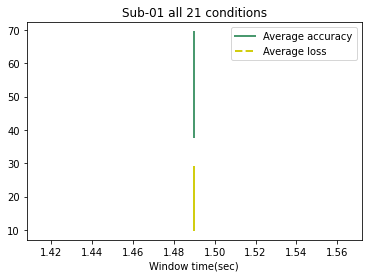

In [24]:
# multiple line plots

plt.plot( 'time_window', 'average_accuracy', data=df, marker='', 
         color='#4a996f', linewidth=2, label='Average accuracy')
plt.plot( 'time_window', 'average_loss', data=df, marker='', color='#d1cd10', 
         linewidth=2, linestyle='dashed', label='Average loss')
plt.title('Sub-01 all 21 conditions')
plt.xlabel("Window time(sec)")

# show legend
plt.legend()

# show graph
plt.show()